In [1]:
pip install matplotlib diffusers transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471

In [2]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import get_linear_schedule_with_warmup  # Warm‑up scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR  # (optional if you swap later)

# 1) Reproducibility: seed for splits & sampling
torch.manual_seed(42)

# 2) Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3) Ensure output directory exists
os.makedirs("outputs", exist_ok=True)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
# 0) Load your fine‑tuned VAE directly
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="vae"
).to(device)
ckpt = torch.load("best_fine_tuned_vae.pth", map_location=device)
missing, unexpected = vae.load_state_dict(ckpt, strict=False)
print("VAE missing keys:", missing)
print("VAE unexpected keys:", unexpected)
vae.eval()

# 1) Grab its scaling factor
scale = vae.config.scaling_factor  # ≈0.18215

# 2) Load precomputed raw latents + text embeddings
data            = torch.load("latent_text_data.pt")
latents_raw     = data["z"].float()                     # [N,4,32,32], raw
text_embeddings = data["text_embeddings"].float().unsqueeze(1)

# 3) Deterministic splits
total_samples = len(latents_raw)
perm      = torch.randperm(total_samples, generator=torch.Generator().manual_seed(42))
train_end = int(0.8 * total_samples)
val_end   = train_end + int(0.1 * total_samples)

train_idx = perm[:train_end]
val_idx   = perm[train_end:val_end]
test_idx  = perm[val_end:]

# 4) Dataset that applies the VAE’s scaling
class LatentTextDataset(Dataset):
    def __init__(self, latents_raw, text_embs, scale, noise_level=0.0):
        self.latents_raw = latents_raw
        self.text_embs   = text_embs
        self.scale       = scale
        self.noise_level = noise_level

    def __len__(self):
        return len(self.latents_raw)

    def __getitem__(self, idx):
        # 1) raw latent → apply scale
        z = self.latents_raw[idx] * self.scale
        # 2) optional tiny augmentation
        if self.noise_level > 0:
            z = z + torch.randn_like(z) * self.noise_level
        return z, self.text_embs[idx]

# 5) Build your splits & loaders
train_ds = LatentTextDataset(latents_raw[train_idx], text_embeddings[train_idx], scale, noise_level=0.02)
val_ds   = LatentTextDataset(latents_raw[val_idx],   text_embeddings[val_idx],   scale, noise_level=0.0)
test_ds  = LatentTextDataset(latents_raw[test_idx],  text_embeddings[test_idx],  scale, noise_level=0.0)

batch_size   = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Sizes - train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

VAE missing keys: []
VAE unexpected keys: []
Sizes - train: 7658, val: 957, test: 958


In [4]:
# === Cell: Models & Scheduler Definitions ===

# 1) DDIM Scheduler (unchanged)
class DDIMScheduler:
    def __init__(self, num_train_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.num_train_timesteps = num_train_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def add_noise(self, x0, t, noise):
        a = self.sqrt_alpha_cumprod[t][:, None, None, None]
        b = self.sqrt_one_minus_alpha_cumprod[t][:, None, None, None]
        return a * x0 + b * noise

    def _get_prev(self, t, steps):
        step_ratio = self.num_train_timesteps // steps
        prev = torch.clamp(t - step_ratio, min=0).to(device)
        return prev

    def step(self, model_out, t, sample, guidance_scale, num_inference_steps):
        if isinstance(t, int):
            t = torch.tensor([t], device=device)
        if t.dim()==0:
            t = t.unsqueeze(0)
        prev_t    = self._get_prev(t, num_inference_steps)
        alpha_t   = self.alpha_cumprod[t][:,None,None,None]
        alpha_prev= self.alpha_cumprod[prev_t][:,None,None,None]
        pred_orig = (sample - torch.sqrt(1-alpha_t)*model_out) / torch.sqrt(alpha_t)
        sigma     = torch.sqrt((1-alpha_prev)/(1-alpha_t) * (1 - alpha_t/alpha_prev))
        return torch.sqrt(alpha_prev)*pred_orig + sigma * model_out

    def get_timesteps_for_inference(self, steps):
        ratio = self.num_train_timesteps // steps
        ts = list(range(0, self.num_train_timesteps, ratio))
        return sorted(ts, reverse=True)


# 2) Text‑conditioned U‑Net (unchanged)
class TextConditionedUNet(nn.Module):
    def __init__(self, text_dim=512):
        super().__init__()
        self.unet = UNet2DConditionModel(
            sample_size=32, in_channels=4, out_channels=4,
            layers_per_block=2, block_out_channels=(256,512,768,1024),
            down_block_types=("DownBlock2D","DownBlock2D","CrossAttnDownBlock2D","CrossAttnDownBlock2D"),
            up_block_types=("CrossAttnUpBlock2D","CrossAttnUpBlock2D","UpBlock2D","UpBlock2D"),
            cross_attention_dim=text_dim, attention_head_dim=64, dropout=0.1
        ).to(device)

    def forward(self, x, t, emb, guidance_scale=1.0):
        if guidance_scale == 1.0:
            return self.unet(x, t, encoder_hidden_states=emb).sample
        uncond    = torch.zeros_like(emb)
        emb_cat   = torch.cat([uncond, emb], dim=0)
        x_cat     = torch.cat([x, x], dim=0)
        t_cat     = torch.cat([t, t], dim=0)
        pred      = self.unet(x_cat, t_cat, encoder_hidden_states=emb_cat).sample
        noise_u, noise_c = pred.chunk(2)
        return noise_u + guidance_scale * (noise_c - noise_u)


# 3) Load your fine‑tuned VAE directly
from diffusers import AutoencoderKL
vae = AutoencoderKL.from_pretrained(
    "runwayml/stable-diffusion-v1-5", subfolder="vae"
).to(device)
ckpt = torch.load("best_fine_tuned_vae.pth", map_location=device)
missing, unexpected = vae.load_state_dict(ckpt, strict=False)
print("VAE load — missing keys:", missing)
print("VAE load — unexpected keys:", unexpected)
vae.eval()

# 4) EMA helper (unchanged)
class EMA:
    def __init__(self, model, decay=0.9999):
        self.decay  = decay
        self.shadow = {n:p.data.clone() for n,p in model.named_parameters() if p.requires_grad}
        self.backup = {}
    def update(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = self.decay * self.shadow[n] + (1-self.decay) * p.data
    def apply_shadow(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.backup[n] = p.data
                p.data        = self.shadow[n]
    def restore(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                p.data = self.backup[n]
        self.backup.clear()
    def state_dict(self):    return self.shadow
    def load_state_dict(self, sd): self.shadow = sd

# 5) Instantiate UNet, scheduler, EMA
unet      = TextConditionedUNet(text_dim=512)
scheduler = DDIMScheduler(num_train_timesteps=1000)
ema       = EMA(unet)

VAE load — missing keys: []
VAE load — unexpected keys: []


In [5]:
optimizer = optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-2)

num_epochs    = 200
steps_per_ep  = len(train_loader)
total_steps   = num_epochs * steps_per_ep
warmup_steps  = steps_per_ep * 5  # first 5 epochs

# Linear warm-up → linear decay (you can swap to cosine after warmup if desired)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [6]:
# === Cell 5: Training + Validation + (Visualization every epoch) + Checkpointing ===

# Prepare lists to record losses
train_losses = []
val_losses   = []

best_val_loss    = float("inf")
patience         = 15
patience_counter = 0
grad_accum_steps = 4

# Pre‑select 3 fixed validation samples for progress visualization
# (these val_ds samples yield *scaled* latents already)
val_samples = [
    (val_ds[i][0].unsqueeze(0), val_ds[i][1].unsqueeze(0))
    for i in range(3)
]

# Grab scaling factor from your fine‑tuned VAE
s = vae.config.scaling_factor

for epoch in range(1, num_epochs + 1):
    # ————— Training Phase —————
    unet.train()
    optimizer.zero_grad()
    running_loss = 0.0

    for step, (zb, emb) in enumerate(
            tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{num_epochs}"), 1):
        zb, emb = zb.to(device), emb.to(device)
        batch   = zb.size(0)

        # 1) Forward noising
        t     = torch.randint(0, scheduler.num_train_timesteps, (batch,), device=device)
        noise = torch.randn_like(zb, device=device)
        noisy = scheduler.add_noise(zb, t, noise)

        # 2) Predict noise and compute loss
        noise_pred = unet(noisy, t, emb, guidance_scale=1.0)
        loss       = nn.functional.mse_loss(noise_pred, noise) / grad_accum_steps
        loss.backward()
        running_loss += loss.item() * grad_accum_steps

        # 3) Gradient accumulation step
        if step % grad_accum_steps == 0 or step == len(train_loader):
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            ema.update(unet)

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch} — Train Loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)

    # ————— Validation Phase —————
    unet.eval()
    ema.apply_shadow(unet)
    val_loss = 0.0

    with torch.no_grad():
        for zb, emb in tqdm(val_loader, desc=f"[Val] Epoch {epoch}/{num_epochs}"):
            zb, emb = zb.to(device), emb.to(device)
            batch   = zb.size(0)

            t     = torch.randint(0, scheduler.num_train_timesteps, (batch,), device=device)
            noise = torch.randn_like(zb, device=device)
            noisy = scheduler.add_noise(zb, t, noise)

            noise_pred = unet(noisy, t, emb, guidance_scale=1.0)
            val_loss  += nn.functional.mse_loss(noise_pred, noise).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch} — Val  Loss: {val_loss:.4f}")
    val_losses.append(val_loss)
    ema.restore(unet)

    # ————— Sampling & Visualization (every epoch) —————
    unet.eval()
    ema.apply_shadow(unet)

    with torch.no_grad():
        # a) Original VAE reconstruction of our fixed z0
        z0, emb0 = val_samples[0]
        z0       = z0.to(device)                   # already = z_raw * s
        recon0   = vae.decode(z0).sample.clamp(0,1) # decode expects scaled input
        orig_img = recon0[0].permute(1,2,0).cpu()

        # b) Diffusion progression from pure noise
        x_t = torch.randn_like(z0, device=device)
        latents_chain = [x_t.cpu()]
        timesteps      = scheduler.get_timesteps_for_inference(steps=100)
        for step in timesteps:
            t_tensor   = torch.tensor([step], device=device)
            noise_pred = unet(x_t, t_tensor, emb0.to(device), guidance_scale=8.5)
            x_t        = scheduler.step(
                             noise_pred, t_tensor, x_t,
                             guidance_scale=8.5,
                             num_inference_steps=100
                         )
            # capture 5 evenly spaced snapshots
            if step % (scheduler.num_train_timesteps // 5) == 0:
                latents_chain.append(x_t.cpu())

        # c) Plot side‑by‑side
        total = 1 + len(latents_chain)
        fig, axs = plt.subplots(1, total, figsize=(3*total, 3))

        # 1) VAE's direct reconstruction
        axs[0].imshow(orig_img)
        axs[0].set_title("VAE Recon")
        axs[0].axis("off")

        # 2…) Init and denoising steps
        for i, latent in enumerate(latents_chain, start=1):
            img_t = vae.decode(latent.to(device)).sample.clamp(0,1)
            img   = img_t[0].permute(1,2,0).cpu()
            axs[i].imshow(img)
            axs[i].set_title("Init" if i==1 else f"Step {i-1}")
            axs[i].axis("off")

        plt.tight_layout()
        plt.savefig(f"outputs/progression_epoch_{epoch}.png")
        plt.close()

    ema.restore(unet)

    # ————— Checkpointing & Early Stopping —————
    if val_loss < best_val_loss:
        best_val_loss    = val_loss
        patience_counter = 0
        torch.save(unet.state_dict(), "outputs/best_diffusion_model.pth")
        torch.save(ema.state_dict(),  "outputs/best_diffusion_model_ema.pth")
        print(f"Saved new best model (Val Loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement (patience {patience_counter}/{patience})")
        if patience_counter >= patience:
            print("Early stopping triggered; exiting training loop")
            break

[Train] Epoch 1/200: 100%|██████████| 958/958 [01:26<00:00, 11.07it/s]


Epoch 1 — Train Loss: 0.6082


[Val] Epoch 1/200: 100%|██████████| 120/120 [00:02<00:00, 42.75it/s]


Epoch 1 — Val  Loss: 1.1349
Saved new best model (Val Loss: 1.1349)


[Train] Epoch 2/200: 100%|██████████| 958/958 [01:26<00:00, 11.14it/s]


Epoch 2 — Train Loss: 0.1779


[Val] Epoch 2/200: 100%|██████████| 120/120 [00:02<00:00, 41.65it/s]


Epoch 2 — Val  Loss: 1.0913
Saved new best model (Val Loss: 1.0913)


[Train] Epoch 3/200: 100%|██████████| 958/958 [01:26<00:00, 11.14it/s]


Epoch 3 — Train Loss: 0.1401


[Val] Epoch 3/200: 100%|██████████| 120/120 [00:02<00:00, 43.25it/s]


Epoch 3 — Val  Loss: 1.0420
Saved new best model (Val Loss: 1.0420)


[Train] Epoch 4/200: 100%|██████████| 958/958 [01:25<00:00, 11.17it/s]


Epoch 4 — Train Loss: 0.1207


[Val] Epoch 4/200: 100%|██████████| 120/120 [00:02<00:00, 43.54it/s]


Epoch 4 — Val  Loss: 0.9860
Saved new best model (Val Loss: 0.9860)


[Train] Epoch 5/200: 100%|██████████| 958/958 [01:26<00:00, 11.11it/s]


Epoch 5 — Train Loss: 0.1177


[Val] Epoch 5/200: 100%|██████████| 120/120 [00:02<00:00, 45.28it/s]


Epoch 5 — Val  Loss: 0.9282
Saved new best model (Val Loss: 0.9282)


[Train] Epoch 6/200: 100%|██████████| 958/958 [01:23<00:00, 11.47it/s]


Epoch 6 — Train Loss: 0.1132


[Val] Epoch 6/200: 100%|██████████| 120/120 [00:02<00:00, 43.00it/s]


Epoch 6 — Val  Loss: 0.8687
Saved new best model (Val Loss: 0.8687)


[Train] Epoch 7/200: 100%|██████████| 958/958 [01:22<00:00, 11.60it/s]


Epoch 7 — Train Loss: 0.1107


[Val] Epoch 7/200: 100%|██████████| 120/120 [00:02<00:00, 45.56it/s]


Epoch 7 — Val  Loss: 0.8066
Saved new best model (Val Loss: 0.8066)


[Train] Epoch 8/200: 100%|██████████| 958/958 [01:22<00:00, 11.57it/s]


Epoch 8 — Train Loss: 0.1054


[Val] Epoch 8/200: 100%|██████████| 120/120 [00:02<00:00, 44.83it/s]


Epoch 8 — Val  Loss: 0.7425
Saved new best model (Val Loss: 0.7425)


[Train] Epoch 9/200: 100%|██████████| 958/958 [01:22<00:00, 11.62it/s]


Epoch 9 — Train Loss: 0.1001


[Val] Epoch 9/200: 100%|██████████| 120/120 [00:02<00:00, 45.65it/s]


Epoch 9 — Val  Loss: 0.6723
Saved new best model (Val Loss: 0.6723)


[Train] Epoch 10/200: 100%|██████████| 958/958 [01:22<00:00, 11.57it/s]


Epoch 10 — Train Loss: 0.1013


[Val] Epoch 10/200: 100%|██████████| 120/120 [00:02<00:00, 44.31it/s]


Epoch 10 — Val  Loss: 0.6066
Saved new best model (Val Loss: 0.6066)


[Train] Epoch 11/200: 100%|██████████| 958/958 [01:22<00:00, 11.61it/s]


Epoch 11 — Train Loss: 0.0911


[Val] Epoch 11/200: 100%|██████████| 120/120 [00:02<00:00, 44.81it/s]


Epoch 11 — Val  Loss: 0.5558
Saved new best model (Val Loss: 0.5558)


[Train] Epoch 12/200: 100%|██████████| 958/958 [01:22<00:00, 11.65it/s]


Epoch 12 — Train Loss: 0.0904


[Val] Epoch 12/200: 100%|██████████| 120/120 [00:02<00:00, 45.42it/s]


Epoch 12 — Val  Loss: 0.5034
Saved new best model (Val Loss: 0.5034)


[Train] Epoch 13/200: 100%|██████████| 958/958 [01:22<00:00, 11.59it/s]


Epoch 13 — Train Loss: 0.0910


[Val] Epoch 13/200: 100%|██████████| 120/120 [00:02<00:00, 45.94it/s]


Epoch 13 — Val  Loss: 0.4479
Saved new best model (Val Loss: 0.4479)


[Train] Epoch 14/200: 100%|██████████| 958/958 [01:23<00:00, 11.49it/s]


Epoch 14 — Train Loss: 0.0881


[Val] Epoch 14/200: 100%|██████████| 120/120 [00:02<00:00, 45.58it/s]


Epoch 14 — Val  Loss: 0.3977
Saved new best model (Val Loss: 0.3977)


[Train] Epoch 15/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 15 — Train Loss: 0.0876


[Val] Epoch 15/200: 100%|██████████| 120/120 [00:02<00:00, 46.08it/s]


Epoch 15 — Val  Loss: 0.3612
Saved new best model (Val Loss: 0.3612)


[Train] Epoch 16/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 16 — Train Loss: 0.0854


[Val] Epoch 16/200: 100%|██████████| 120/120 [00:02<00:00, 45.39it/s]


Epoch 16 — Val  Loss: 0.3211
Saved new best model (Val Loss: 0.3211)


[Train] Epoch 17/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 17 — Train Loss: 0.0856


[Val] Epoch 17/200: 100%|██████████| 120/120 [00:02<00:00, 45.48it/s]


Epoch 17 — Val  Loss: 0.2909
Saved new best model (Val Loss: 0.2909)


[Train] Epoch 18/200: 100%|██████████| 958/958 [01:22<00:00, 11.65it/s]


Epoch 18 — Train Loss: 0.0847


[Val] Epoch 18/200: 100%|██████████| 120/120 [00:02<00:00, 45.73it/s]


Epoch 18 — Val  Loss: 0.2466
Saved new best model (Val Loss: 0.2466)


[Train] Epoch 19/200: 100%|██████████| 958/958 [01:22<00:00, 11.59it/s]


Epoch 19 — Train Loss: 0.0795


[Val] Epoch 19/200: 100%|██████████| 120/120 [00:02<00:00, 44.93it/s]


Epoch 19 — Val  Loss: 0.2397
Saved new best model (Val Loss: 0.2397)


[Train] Epoch 20/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 20 — Train Loss: 0.0789


[Val] Epoch 20/200: 100%|██████████| 120/120 [00:02<00:00, 45.09it/s]


Epoch 20 — Val  Loss: 0.2069
Saved new best model (Val Loss: 0.2069)


[Train] Epoch 21/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 21 — Train Loss: 0.0796


[Val] Epoch 21/200: 100%|██████████| 120/120 [00:02<00:00, 45.88it/s]


Epoch 21 — Val  Loss: 0.1927
Saved new best model (Val Loss: 0.1927)


[Train] Epoch 22/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 22 — Train Loss: 0.0804


[Val] Epoch 22/200: 100%|██████████| 120/120 [00:02<00:00, 44.88it/s]


Epoch 22 — Val  Loss: 0.1778
Saved new best model (Val Loss: 0.1778)


[Train] Epoch 23/200: 100%|██████████| 958/958 [01:22<00:00, 11.62it/s]


Epoch 23 — Train Loss: 0.0762


[Val] Epoch 23/200: 100%|██████████| 120/120 [00:02<00:00, 46.01it/s]


Epoch 23 — Val  Loss: 0.1573
Saved new best model (Val Loss: 0.1573)


[Train] Epoch 24/200: 100%|██████████| 958/958 [01:21<00:00, 11.70it/s]


Epoch 24 — Train Loss: 0.0770


[Val] Epoch 24/200: 100%|██████████| 120/120 [00:02<00:00, 44.24it/s]


Epoch 24 — Val  Loss: 0.1654
No improvement (patience 1/15)


[Train] Epoch 25/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 25 — Train Loss: 0.0759


[Val] Epoch 25/200: 100%|██████████| 120/120 [00:02<00:00, 45.72it/s]


Epoch 25 — Val  Loss: 0.1478
Saved new best model (Val Loss: 0.1478)


[Train] Epoch 26/200: 100%|██████████| 958/958 [01:21<00:00, 11.68it/s]


Epoch 26 — Train Loss: 0.0758


[Val] Epoch 26/200: 100%|██████████| 120/120 [00:02<00:00, 45.19it/s]


Epoch 26 — Val  Loss: 0.1416
Saved new best model (Val Loss: 0.1416)


[Train] Epoch 27/200: 100%|██████████| 958/958 [01:22<00:00, 11.68it/s]


Epoch 27 — Train Loss: 0.0756


[Val] Epoch 27/200: 100%|██████████| 120/120 [00:02<00:00, 46.12it/s]


Epoch 27 — Val  Loss: 0.1488
No improvement (patience 1/15)


[Train] Epoch 28/200: 100%|██████████| 958/958 [01:22<00:00, 11.68it/s]


Epoch 28 — Train Loss: 0.0727


[Val] Epoch 28/200: 100%|██████████| 120/120 [00:02<00:00, 45.58it/s]


Epoch 28 — Val  Loss: 0.1364
Saved new best model (Val Loss: 0.1364)


[Train] Epoch 29/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 29 — Train Loss: 0.0713


[Val] Epoch 29/200: 100%|██████████| 120/120 [00:02<00:00, 45.48it/s]


Epoch 29 — Val  Loss: 0.1353
Saved new best model (Val Loss: 0.1353)


[Train] Epoch 30/200: 100%|██████████| 958/958 [01:22<00:00, 11.68it/s]


Epoch 30 — Train Loss: 0.0739


[Val] Epoch 30/200: 100%|██████████| 120/120 [00:02<00:00, 45.57it/s]


Epoch 30 — Val  Loss: 0.1410
No improvement (patience 1/15)


[Train] Epoch 31/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 31 — Train Loss: 0.0713


[Val] Epoch 31/200: 100%|██████████| 120/120 [00:02<00:00, 45.33it/s]


Epoch 31 — Val  Loss: 0.1274
Saved new best model (Val Loss: 0.1274)


[Train] Epoch 32/200: 100%|██████████| 958/958 [01:22<00:00, 11.57it/s]


Epoch 32 — Train Loss: 0.0716


[Val] Epoch 32/200: 100%|██████████| 120/120 [00:02<00:00, 45.32it/s]


Epoch 32 — Val  Loss: 0.1231
Saved new best model (Val Loss: 0.1231)


[Train] Epoch 33/200: 100%|██████████| 958/958 [01:24<00:00, 11.30it/s]


Epoch 33 — Train Loss: 0.0706


[Val] Epoch 33/200: 100%|██████████| 120/120 [00:02<00:00, 43.46it/s]


Epoch 33 — Val  Loss: 0.1248
No improvement (patience 1/15)


[Train] Epoch 34/200: 100%|██████████| 958/958 [01:24<00:00, 11.35it/s]


Epoch 34 — Train Loss: 0.0714


[Val] Epoch 34/200: 100%|██████████| 120/120 [00:02<00:00, 43.82it/s]


Epoch 34 — Val  Loss: 0.1188
Saved new best model (Val Loss: 0.1188)


[Train] Epoch 35/200: 100%|██████████| 958/958 [01:23<00:00, 11.50it/s]


Epoch 35 — Train Loss: 0.0687


[Val] Epoch 35/200: 100%|██████████| 120/120 [00:02<00:00, 44.91it/s]


Epoch 35 — Val  Loss: 0.1199
No improvement (patience 1/15)


[Train] Epoch 36/200: 100%|██████████| 958/958 [01:22<00:00, 11.58it/s]


Epoch 36 — Train Loss: 0.0700


[Val] Epoch 36/200: 100%|██████████| 120/120 [00:02<00:00, 45.45it/s]


Epoch 36 — Val  Loss: 0.1178
Saved new best model (Val Loss: 0.1178)


[Train] Epoch 37/200: 100%|██████████| 958/958 [01:22<00:00, 11.63it/s]


Epoch 37 — Train Loss: 0.0699


[Val] Epoch 37/200: 100%|██████████| 120/120 [00:02<00:00, 45.94it/s]


Epoch 37 — Val  Loss: 0.1113
Saved new best model (Val Loss: 0.1113)


[Train] Epoch 38/200: 100%|██████████| 958/958 [01:22<00:00, 11.68it/s]


Epoch 38 — Train Loss: 0.0675


[Val] Epoch 38/200: 100%|██████████| 120/120 [00:02<00:00, 45.89it/s]


Epoch 38 — Val  Loss: 0.1089
Saved new best model (Val Loss: 0.1089)


[Train] Epoch 39/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 39 — Train Loss: 0.0680


[Val] Epoch 39/200: 100%|██████████| 120/120 [00:02<00:00, 45.86it/s]


Epoch 39 — Val  Loss: 0.1146
No improvement (patience 1/15)


[Train] Epoch 40/200: 100%|██████████| 958/958 [01:22<00:00, 11.65it/s]


Epoch 40 — Train Loss: 0.0687


[Val] Epoch 40/200: 100%|██████████| 120/120 [00:02<00:00, 45.65it/s]


Epoch 40 — Val  Loss: 0.1070
Saved new best model (Val Loss: 0.1070)


[Train] Epoch 41/200: 100%|██████████| 958/958 [01:22<00:00, 11.68it/s]


Epoch 41 — Train Loss: 0.0675


[Val] Epoch 41/200: 100%|██████████| 120/120 [00:02<00:00, 45.75it/s]


Epoch 41 — Val  Loss: 0.0960
Saved new best model (Val Loss: 0.0960)


[Train] Epoch 42/200: 100%|██████████| 958/958 [01:22<00:00, 11.58it/s]


Epoch 42 — Train Loss: 0.0677


[Val] Epoch 42/200: 100%|██████████| 120/120 [00:02<00:00, 45.40it/s]


Epoch 42 — Val  Loss: 0.0976
No improvement (patience 1/15)


[Train] Epoch 43/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 43 — Train Loss: 0.0685


[Val] Epoch 43/200: 100%|██████████| 120/120 [00:02<00:00, 45.42it/s]


Epoch 43 — Val  Loss: 0.1103
No improvement (patience 2/15)


[Train] Epoch 44/200: 100%|██████████| 958/958 [01:21<00:00, 11.70it/s]


Epoch 44 — Train Loss: 0.0652


[Val] Epoch 44/200: 100%|██████████| 120/120 [00:02<00:00, 45.41it/s]


Epoch 44 — Val  Loss: 0.0974
No improvement (patience 3/15)


[Train] Epoch 45/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 45 — Train Loss: 0.0661


[Val] Epoch 45/200: 100%|██████████| 120/120 [00:02<00:00, 45.76it/s]


Epoch 45 — Val  Loss: 0.1060
No improvement (patience 4/15)


[Train] Epoch 46/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 46 — Train Loss: 0.0648


[Val] Epoch 46/200: 100%|██████████| 120/120 [00:02<00:00, 45.68it/s]


Epoch 46 — Val  Loss: 0.0925
Saved new best model (Val Loss: 0.0925)


[Train] Epoch 47/200: 100%|██████████| 958/958 [01:21<00:00, 11.70it/s]


Epoch 47 — Train Loss: 0.0677


[Val] Epoch 47/200: 100%|██████████| 120/120 [00:02<00:00, 45.90it/s]


Epoch 47 — Val  Loss: 0.0993
No improvement (patience 1/15)


[Train] Epoch 48/200: 100%|██████████| 958/958 [01:22<00:00, 11.68it/s]


Epoch 48 — Train Loss: 0.0646


[Val] Epoch 48/200: 100%|██████████| 120/120 [00:02<00:00, 45.71it/s]


Epoch 48 — Val  Loss: 0.0977
No improvement (patience 2/15)


[Train] Epoch 49/200: 100%|██████████| 958/958 [01:22<00:00, 11.65it/s]


Epoch 49 — Train Loss: 0.0651


[Val] Epoch 49/200: 100%|██████████| 120/120 [00:02<00:00, 45.53it/s]


Epoch 49 — Val  Loss: 0.0921
Saved new best model (Val Loss: 0.0921)


[Train] Epoch 50/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 50 — Train Loss: 0.0650


[Val] Epoch 50/200: 100%|██████████| 120/120 [00:02<00:00, 45.77it/s]


Epoch 50 — Val  Loss: 0.1062
No improvement (patience 1/15)


[Train] Epoch 51/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 51 — Train Loss: 0.0659


[Val] Epoch 51/200: 100%|██████████| 120/120 [00:02<00:00, 45.67it/s]


Epoch 51 — Val  Loss: 0.0874
Saved new best model (Val Loss: 0.0874)


[Train] Epoch 52/200: 100%|██████████| 958/958 [01:22<00:00, 11.60it/s]


Epoch 52 — Train Loss: 0.0642


[Val] Epoch 52/200: 100%|██████████| 120/120 [00:02<00:00, 45.27it/s]


Epoch 52 — Val  Loss: 0.0911
No improvement (patience 1/15)


[Train] Epoch 53/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 53 — Train Loss: 0.0638


[Val] Epoch 53/200: 100%|██████████| 120/120 [00:02<00:00, 45.60it/s]


Epoch 53 — Val  Loss: 0.0855
Saved new best model (Val Loss: 0.0855)


[Train] Epoch 54/200: 100%|██████████| 958/958 [01:22<00:00, 11.65it/s]


Epoch 54 — Train Loss: 0.0627


[Val] Epoch 54/200: 100%|██████████| 120/120 [00:02<00:00, 44.92it/s]


Epoch 54 — Val  Loss: 0.0932
No improvement (patience 1/15)


[Train] Epoch 55/200: 100%|██████████| 958/958 [01:21<00:00, 11.72it/s]


Epoch 55 — Train Loss: 0.0654


[Val] Epoch 55/200: 100%|██████████| 120/120 [00:02<00:00, 44.77it/s]


Epoch 55 — Val  Loss: 0.0792
Saved new best model (Val Loss: 0.0792)


[Train] Epoch 56/200: 100%|██████████| 958/958 [01:22<00:00, 11.64it/s]


Epoch 56 — Train Loss: 0.0649


[Val] Epoch 56/200: 100%|██████████| 120/120 [00:02<00:00, 44.50it/s]


Epoch 56 — Val  Loss: 0.0890
No improvement (patience 1/15)


[Train] Epoch 57/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 57 — Train Loss: 0.0638


[Val] Epoch 57/200: 100%|██████████| 120/120 [00:02<00:00, 44.69it/s]


Epoch 57 — Val  Loss: 0.0815
No improvement (patience 2/15)


[Train] Epoch 58/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 58 — Train Loss: 0.0626


[Val] Epoch 58/200: 100%|██████████| 120/120 [00:02<00:00, 45.62it/s]


Epoch 58 — Val  Loss: 0.0891
No improvement (patience 3/15)


[Train] Epoch 59/200: 100%|██████████| 958/958 [01:22<00:00, 11.65it/s]


Epoch 59 — Train Loss: 0.0639


[Val] Epoch 59/200: 100%|██████████| 120/120 [00:02<00:00, 45.56it/s]


Epoch 59 — Val  Loss: 0.0813
No improvement (patience 4/15)


[Train] Epoch 60/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 60 — Train Loss: 0.0627


[Val] Epoch 60/200: 100%|██████████| 120/120 [00:02<00:00, 45.76it/s]


Epoch 60 — Val  Loss: 0.0777
Saved new best model (Val Loss: 0.0777)


[Train] Epoch 61/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 61 — Train Loss: 0.0638


[Val] Epoch 61/200: 100%|██████████| 120/120 [00:02<00:00, 45.06it/s]


Epoch 61 — Val  Loss: 0.0731
Saved new best model (Val Loss: 0.0731)


[Train] Epoch 62/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 62 — Train Loss: 0.0618


[Val] Epoch 62/200: 100%|██████████| 120/120 [00:02<00:00, 44.67it/s]


Epoch 62 — Val  Loss: 0.0753
No improvement (patience 1/15)


[Train] Epoch 63/200: 100%|██████████| 958/958 [01:22<00:00, 11.63it/s]


Epoch 63 — Train Loss: 0.0590


[Val] Epoch 63/200: 100%|██████████| 120/120 [00:02<00:00, 45.77it/s]


Epoch 63 — Val  Loss: 0.0768
No improvement (patience 2/15)


[Train] Epoch 64/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 64 — Train Loss: 0.0617


[Val] Epoch 64/200: 100%|██████████| 120/120 [00:02<00:00, 45.27it/s]


Epoch 64 — Val  Loss: 0.0863
No improvement (patience 3/15)


[Train] Epoch 65/200: 100%|██████████| 958/958 [01:21<00:00, 11.70it/s]


Epoch 65 — Train Loss: 0.0634


[Val] Epoch 65/200: 100%|██████████| 120/120 [00:02<00:00, 44.72it/s]


Epoch 65 — Val  Loss: 0.0792
No improvement (patience 4/15)


[Train] Epoch 66/200: 100%|██████████| 958/958 [01:21<00:00, 11.72it/s]


Epoch 66 — Train Loss: 0.0647


[Val] Epoch 66/200: 100%|██████████| 120/120 [00:02<00:00, 45.65it/s]


Epoch 66 — Val  Loss: 0.0778
No improvement (patience 5/15)


[Train] Epoch 67/200: 100%|██████████| 958/958 [01:22<00:00, 11.55it/s]


Epoch 67 — Train Loss: 0.0617


[Val] Epoch 67/200: 100%|██████████| 120/120 [00:02<00:00, 44.40it/s]


Epoch 67 — Val  Loss: 0.0781
No improvement (patience 6/15)


[Train] Epoch 68/200: 100%|██████████| 958/958 [01:22<00:00, 11.56it/s]


Epoch 68 — Train Loss: 0.0608


[Val] Epoch 68/200: 100%|██████████| 120/120 [00:02<00:00, 43.92it/s]


Epoch 68 — Val  Loss: 0.0760
No improvement (patience 7/15)


[Train] Epoch 69/200: 100%|██████████| 958/958 [01:23<00:00, 11.53it/s]


Epoch 69 — Train Loss: 0.0637


[Val] Epoch 69/200: 100%|██████████| 120/120 [00:02<00:00, 42.07it/s]


Epoch 69 — Val  Loss: 0.0680
Saved new best model (Val Loss: 0.0680)


[Train] Epoch 70/200: 100%|██████████| 958/958 [01:23<00:00, 11.54it/s]


Epoch 70 — Train Loss: 0.0594


[Val] Epoch 70/200: 100%|██████████| 120/120 [00:02<00:00, 44.42it/s]


Epoch 70 — Val  Loss: 0.0792
No improvement (patience 1/15)


[Train] Epoch 71/200: 100%|██████████| 958/958 [01:23<00:00, 11.48it/s]


Epoch 71 — Train Loss: 0.0605


[Val] Epoch 71/200: 100%|██████████| 120/120 [00:02<00:00, 41.79it/s]


Epoch 71 — Val  Loss: 0.0724
No improvement (patience 2/15)


[Train] Epoch 72/200: 100%|██████████| 958/958 [01:22<00:00, 11.55it/s]


Epoch 72 — Train Loss: 0.0614


[Val] Epoch 72/200: 100%|██████████| 120/120 [00:02<00:00, 42.63it/s]


Epoch 72 — Val  Loss: 0.0725
No improvement (patience 3/15)


[Train] Epoch 73/200: 100%|██████████| 958/958 [01:21<00:00, 11.68it/s]


Epoch 73 — Train Loss: 0.0610


[Val] Epoch 73/200: 100%|██████████| 120/120 [00:02<00:00, 44.76it/s]


Epoch 73 — Val  Loss: 0.0719
No improvement (patience 4/15)


[Train] Epoch 74/200: 100%|██████████| 958/958 [01:21<00:00, 11.70it/s]


Epoch 74 — Train Loss: 0.0590


[Val] Epoch 74/200: 100%|██████████| 120/120 [00:02<00:00, 45.32it/s]


Epoch 74 — Val  Loss: 0.0752
No improvement (patience 5/15)


[Train] Epoch 75/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 75 — Train Loss: 0.0610


[Val] Epoch 75/200: 100%|██████████| 120/120 [00:02<00:00, 45.50it/s]


Epoch 75 — Val  Loss: 0.0687
No improvement (patience 6/15)


[Train] Epoch 76/200: 100%|██████████| 958/958 [01:21<00:00, 11.70it/s]


Epoch 76 — Train Loss: 0.0592


[Val] Epoch 76/200: 100%|██████████| 120/120 [00:02<00:00, 45.09it/s]


Epoch 76 — Val  Loss: 0.0684
No improvement (patience 7/15)


[Train] Epoch 77/200: 100%|██████████| 958/958 [01:21<00:00, 11.73it/s]


Epoch 77 — Train Loss: 0.0570


[Val] Epoch 77/200: 100%|██████████| 120/120 [00:02<00:00, 45.35it/s]


Epoch 77 — Val  Loss: 0.0622
Saved new best model (Val Loss: 0.0622)


[Train] Epoch 78/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 78 — Train Loss: 0.0618


[Val] Epoch 78/200: 100%|██████████| 120/120 [00:02<00:00, 45.46it/s]


Epoch 78 — Val  Loss: 0.0671
No improvement (patience 1/15)


[Train] Epoch 79/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 79 — Train Loss: 0.0590


[Val] Epoch 79/200: 100%|██████████| 120/120 [00:02<00:00, 42.29it/s]


Epoch 79 — Val  Loss: 0.0630
No improvement (patience 2/15)


[Train] Epoch 80/200: 100%|██████████| 958/958 [01:22<00:00, 11.65it/s]


Epoch 80 — Train Loss: 0.0613


[Val] Epoch 80/200: 100%|██████████| 120/120 [00:02<00:00, 45.52it/s]


Epoch 80 — Val  Loss: 0.0730
No improvement (patience 3/15)


[Train] Epoch 81/200: 100%|██████████| 958/958 [01:22<00:00, 11.59it/s]


Epoch 81 — Train Loss: 0.0573


[Val] Epoch 81/200: 100%|██████████| 120/120 [00:02<00:00, 44.74it/s]


Epoch 81 — Val  Loss: 0.0636
No improvement (patience 4/15)


[Train] Epoch 82/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 82 — Train Loss: 0.0612


[Val] Epoch 82/200: 100%|██████████| 120/120 [00:02<00:00, 45.35it/s]


Epoch 82 — Val  Loss: 0.0649
No improvement (patience 5/15)


[Train] Epoch 83/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 83 — Train Loss: 0.0593


[Val] Epoch 83/200: 100%|██████████| 120/120 [00:02<00:00, 45.29it/s]


Epoch 83 — Val  Loss: 0.0628
No improvement (patience 6/15)


[Train] Epoch 84/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 84 — Train Loss: 0.0601


[Val] Epoch 84/200: 100%|██████████| 120/120 [00:02<00:00, 45.26it/s]


Epoch 84 — Val  Loss: 0.0663
No improvement (patience 7/15)


[Train] Epoch 85/200: 100%|██████████| 958/958 [01:22<00:00, 11.63it/s]


Epoch 85 — Train Loss: 0.0601


[Val] Epoch 85/200: 100%|██████████| 120/120 [00:02<00:00, 44.96it/s]


Epoch 85 — Val  Loss: 0.0646
No improvement (patience 8/15)


[Train] Epoch 86/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 86 — Train Loss: 0.0593


[Val] Epoch 86/200: 100%|██████████| 120/120 [00:02<00:00, 45.36it/s]


Epoch 86 — Val  Loss: 0.0596
Saved new best model (Val Loss: 0.0596)


[Train] Epoch 87/200: 100%|██████████| 958/958 [01:22<00:00, 11.65it/s]


Epoch 87 — Train Loss: 0.0574


[Val] Epoch 87/200: 100%|██████████| 120/120 [00:02<00:00, 45.13it/s]


Epoch 87 — Val  Loss: 0.0657
No improvement (patience 1/15)


[Train] Epoch 88/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 88 — Train Loss: 0.0584


[Val] Epoch 88/200: 100%|██████████| 120/120 [00:02<00:00, 45.10it/s]


Epoch 88 — Val  Loss: 0.0649
No improvement (patience 2/15)


[Train] Epoch 89/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 89 — Train Loss: 0.0566


[Val] Epoch 89/200: 100%|██████████| 120/120 [00:02<00:00, 45.22it/s]


Epoch 89 — Val  Loss: 0.0641
No improvement (patience 3/15)


[Train] Epoch 90/200: 100%|██████████| 958/958 [01:22<00:00, 11.56it/s]


Epoch 90 — Train Loss: 0.0589


[Val] Epoch 90/200: 100%|██████████| 120/120 [00:02<00:00, 44.70it/s]


Epoch 90 — Val  Loss: 0.0588
Saved new best model (Val Loss: 0.0588)


[Train] Epoch 91/200: 100%|██████████| 958/958 [01:22<00:00, 11.65it/s]


Epoch 91 — Train Loss: 0.0577


[Val] Epoch 91/200: 100%|██████████| 120/120 [00:02<00:00, 45.25it/s]


Epoch 91 — Val  Loss: 0.0672
No improvement (patience 1/15)


[Train] Epoch 92/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 92 — Train Loss: 0.0584


[Val] Epoch 92/200: 100%|██████████| 120/120 [00:02<00:00, 45.02it/s]


Epoch 92 — Val  Loss: 0.0633
No improvement (patience 2/15)


[Train] Epoch 93/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 93 — Train Loss: 0.0558


[Val] Epoch 93/200: 100%|██████████| 120/120 [00:02<00:00, 45.19it/s]


Epoch 93 — Val  Loss: 0.0588
No improvement (patience 3/15)


[Train] Epoch 94/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 94 — Train Loss: 0.0577


[Val] Epoch 94/200: 100%|██████████| 120/120 [00:02<00:00, 45.04it/s]


Epoch 94 — Val  Loss: 0.0572
Saved new best model (Val Loss: 0.0572)


[Train] Epoch 95/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 95 — Train Loss: 0.0578


[Val] Epoch 95/200: 100%|██████████| 120/120 [00:02<00:00, 45.03it/s]


Epoch 95 — Val  Loss: 0.0663
No improvement (patience 1/15)


[Train] Epoch 96/200: 100%|██████████| 958/958 [01:22<00:00, 11.59it/s]


Epoch 96 — Train Loss: 0.0580


[Val] Epoch 96/200: 100%|██████████| 120/120 [00:02<00:00, 44.90it/s]


Epoch 96 — Val  Loss: 0.0648
No improvement (patience 2/15)


[Train] Epoch 97/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 97 — Train Loss: 0.0566


[Val] Epoch 97/200: 100%|██████████| 120/120 [00:02<00:00, 44.79it/s]


Epoch 97 — Val  Loss: 0.0599
No improvement (patience 3/15)


[Train] Epoch 98/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 98 — Train Loss: 0.0556


[Val] Epoch 98/200: 100%|██████████| 120/120 [00:02<00:00, 44.46it/s]


Epoch 98 — Val  Loss: 0.0630
No improvement (patience 4/15)


[Train] Epoch 99/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 99 — Train Loss: 0.0571


[Val] Epoch 99/200: 100%|██████████| 120/120 [00:02<00:00, 45.13it/s]


Epoch 99 — Val  Loss: 0.0604
No improvement (patience 5/15)


[Train] Epoch 100/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 100 — Train Loss: 0.0577


[Val] Epoch 100/200: 100%|██████████| 120/120 [00:02<00:00, 44.83it/s]


Epoch 100 — Val  Loss: 0.0611
No improvement (patience 6/15)


[Train] Epoch 101/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 101 — Train Loss: 0.0557


[Val] Epoch 101/200: 100%|██████████| 120/120 [00:02<00:00, 45.17it/s]


Epoch 101 — Val  Loss: 0.0692
No improvement (patience 7/15)


[Train] Epoch 102/200: 100%|██████████| 958/958 [01:22<00:00, 11.58it/s]


Epoch 102 — Train Loss: 0.0581


[Val] Epoch 102/200: 100%|██████████| 120/120 [00:02<00:00, 44.47it/s]


Epoch 102 — Val  Loss: 0.0578
No improvement (patience 8/15)


[Train] Epoch 103/200: 100%|██████████| 958/958 [01:21<00:00, 11.70it/s]


Epoch 103 — Train Loss: 0.0559


[Val] Epoch 103/200: 100%|██████████| 120/120 [00:02<00:00, 45.24it/s]


Epoch 103 — Val  Loss: 0.0619
No improvement (patience 9/15)


[Train] Epoch 104/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 104 — Train Loss: 0.0553


[Val] Epoch 104/200: 100%|██████████| 120/120 [00:02<00:00, 43.93it/s]


Epoch 104 — Val  Loss: 0.0564
Saved new best model (Val Loss: 0.0564)


[Train] Epoch 105/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 105 — Train Loss: 0.0540


[Val] Epoch 105/200: 100%|██████████| 120/120 [00:02<00:00, 44.94it/s]


Epoch 105 — Val  Loss: 0.0555
Saved new best model (Val Loss: 0.0555)


[Train] Epoch 106/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 106 — Train Loss: 0.0549


[Val] Epoch 106/200: 100%|██████████| 120/120 [00:02<00:00, 44.88it/s]


Epoch 106 — Val  Loss: 0.0563
No improvement (patience 1/15)


[Train] Epoch 107/200: 100%|██████████| 958/958 [01:22<00:00, 11.58it/s]


Epoch 107 — Train Loss: 0.0546


[Val] Epoch 107/200: 100%|██████████| 120/120 [00:02<00:00, 44.61it/s]


Epoch 107 — Val  Loss: 0.0572
No improvement (patience 2/15)


[Train] Epoch 108/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 108 — Train Loss: 0.0545


[Val] Epoch 108/200: 100%|██████████| 120/120 [00:02<00:00, 44.87it/s]


Epoch 108 — Val  Loss: 0.0608
No improvement (patience 3/15)


[Train] Epoch 109/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 109 — Train Loss: 0.0562


[Val] Epoch 109/200: 100%|██████████| 120/120 [00:02<00:00, 44.91it/s]


Epoch 109 — Val  Loss: 0.0657
No improvement (patience 4/15)


[Train] Epoch 110/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 110 — Train Loss: 0.0545


[Val] Epoch 110/200: 100%|██████████| 120/120 [00:02<00:00, 44.40it/s]


Epoch 110 — Val  Loss: 0.0574
No improvement (patience 5/15)


[Train] Epoch 111/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 111 — Train Loss: 0.0549


[Val] Epoch 111/200: 100%|██████████| 120/120 [00:02<00:00, 44.38it/s]


Epoch 111 — Val  Loss: 0.0567
No improvement (patience 6/15)


[Train] Epoch 112/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 112 — Train Loss: 0.0555


[Val] Epoch 112/200: 100%|██████████| 120/120 [00:02<00:00, 44.89it/s]


Epoch 112 — Val  Loss: 0.0647
No improvement (patience 7/15)


[Train] Epoch 113/200: 100%|██████████| 958/958 [01:22<00:00, 11.60it/s]


Epoch 113 — Train Loss: 0.0540


[Val] Epoch 113/200: 100%|██████████| 120/120 [00:02<00:00, 43.88it/s]


Epoch 113 — Val  Loss: 0.0509
Saved new best model (Val Loss: 0.0509)


[Train] Epoch 114/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 114 — Train Loss: 0.0560


[Val] Epoch 114/200: 100%|██████████| 120/120 [00:02<00:00, 45.18it/s]


Epoch 114 — Val  Loss: 0.0584
No improvement (patience 1/15)


[Train] Epoch 115/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 115 — Train Loss: 0.0558


[Val] Epoch 115/200: 100%|██████████| 120/120 [00:02<00:00, 45.04it/s]


Epoch 115 — Val  Loss: 0.0527
No improvement (patience 2/15)


[Train] Epoch 116/200: 100%|██████████| 958/958 [01:22<00:00, 11.67it/s]


Epoch 116 — Train Loss: 0.0531


[Val] Epoch 116/200: 100%|██████████| 120/120 [00:02<00:00, 44.89it/s]


Epoch 116 — Val  Loss: 0.0556
No improvement (patience 3/15)


[Train] Epoch 117/200: 100%|██████████| 958/958 [01:22<00:00, 11.62it/s]


Epoch 117 — Train Loss: 0.0539


[Val] Epoch 117/200: 100%|██████████| 120/120 [00:02<00:00, 44.93it/s]


Epoch 117 — Val  Loss: 0.0539
No improvement (patience 4/15)


[Train] Epoch 118/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 118 — Train Loss: 0.0569


[Val] Epoch 118/200: 100%|██████████| 120/120 [00:02<00:00, 44.15it/s]


Epoch 118 — Val  Loss: 0.0569
No improvement (patience 5/15)


[Train] Epoch 119/200: 100%|██████████| 958/958 [01:21<00:00, 11.69it/s]


Epoch 119 — Train Loss: 0.0533


[Val] Epoch 119/200: 100%|██████████| 120/120 [00:02<00:00, 44.96it/s]


Epoch 119 — Val  Loss: 0.0547
No improvement (patience 6/15)


[Train] Epoch 120/200: 100%|██████████| 958/958 [01:22<00:00, 11.55it/s]


Epoch 120 — Train Loss: 0.0553


[Val] Epoch 120/200: 100%|██████████| 120/120 [00:02<00:00, 44.87it/s]


Epoch 120 — Val  Loss: 0.0558
No improvement (patience 7/15)


[Train] Epoch 121/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 121 — Train Loss: 0.0541


[Val] Epoch 121/200: 100%|██████████| 120/120 [00:02<00:00, 44.57it/s]


Epoch 121 — Val  Loss: 0.0518
No improvement (patience 8/15)


[Train] Epoch 122/200: 100%|██████████| 958/958 [01:21<00:00, 11.68it/s]


Epoch 122 — Train Loss: 0.0528


[Val] Epoch 122/200: 100%|██████████| 120/120 [00:02<00:00, 44.94it/s]


Epoch 122 — Val  Loss: 0.0556
No improvement (patience 9/15)


[Train] Epoch 123/200: 100%|██████████| 958/958 [01:22<00:00, 11.66it/s]


Epoch 123 — Train Loss: 0.0534


[Val] Epoch 123/200: 100%|██████████| 120/120 [00:02<00:00, 44.55it/s]


Epoch 123 — Val  Loss: 0.0645
No improvement (patience 10/15)


[Train] Epoch 124/200: 100%|██████████| 958/958 [01:21<00:00, 11.70it/s]


Epoch 124 — Train Loss: 0.0539


[Val] Epoch 124/200: 100%|██████████| 120/120 [00:02<00:00, 44.71it/s]


Epoch 124 — Val  Loss: 0.0561
No improvement (patience 11/15)


[Train] Epoch 125/200: 100%|██████████| 958/958 [01:21<00:00, 11.72it/s]


Epoch 125 — Train Loss: 0.0520


[Val] Epoch 125/200: 100%|██████████| 120/120 [00:02<00:00, 44.66it/s]


Epoch 125 — Val  Loss: 0.0536
No improvement (patience 12/15)


[Train] Epoch 126/200: 100%|██████████| 958/958 [01:21<00:00, 11.71it/s]


Epoch 126 — Train Loss: 0.0547


[Val] Epoch 126/200: 100%|██████████| 120/120 [00:02<00:00, 44.56it/s]


Epoch 126 — Val  Loss: 0.0545
No improvement (patience 13/15)


[Train] Epoch 127/200: 100%|██████████| 958/958 [01:22<00:00, 11.56it/s]


Epoch 127 — Train Loss: 0.0557


[Val] Epoch 127/200: 100%|██████████| 120/120 [00:02<00:00, 44.57it/s]


Epoch 127 — Val  Loss: 0.0607
No improvement (patience 14/15)


[Train] Epoch 128/200: 100%|██████████| 958/958 [01:21<00:00, 11.70it/s]


Epoch 128 — Train Loss: 0.0527


[Val] Epoch 128/200: 100%|██████████| 120/120 [00:02<00:00, 44.69it/s]


Epoch 128 — Val  Loss: 0.0572
No improvement (patience 15/15)
Early stopping triggered; exiting training loop


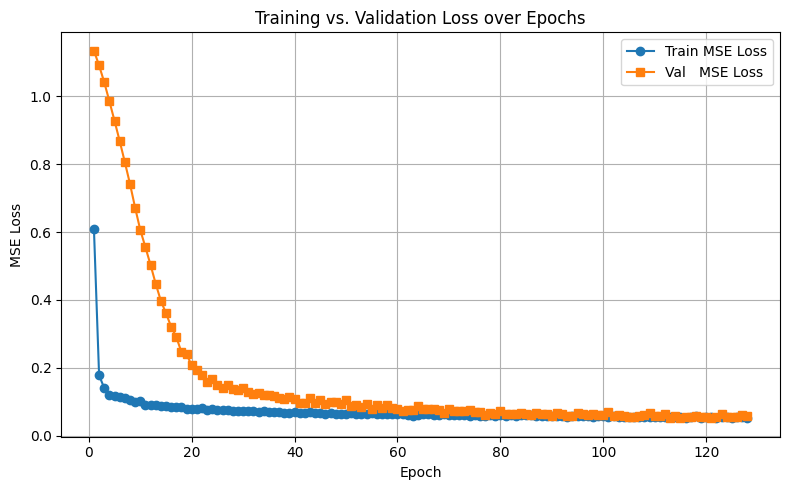

In [10]:
import matplotlib.pyplot as plt

# epochs count
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Train MSE Loss')
plt.plot(epochs, val_losses, marker='s', label='Val   MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Set x-axis ticks every 5 epochs
plt.xticks(range(0, len(epochs)+1, 20))

plt.tight_layout()
plt.show()